# Calibration with NN

In [1]:
import numpy as np
import pandas as pd

import torch 

import sys
sys.path.append('../')

# 导入模型
from NN_Training.NN.nn import NN_pricing

# 评估使用 cpu
device = torch.device('cpu')

# 设置参数为 4 个
hyperparams = { 
    'input_dim': 4, 
    'hidden_dim': 64, 
    'hidden_nums': 10,
    'output_dim': 88,
    'block_layer_nums': 3
}

model = NN_pricing(hyperparams=hyperparams).to(device=device, dtype=torch.float64)


model_state = torch.load( 
    '../Data/Models/nn_rBergomi.pth'
)
model.load_state_dict(model_state)

# 设置为 eval mode
model.eval()
model.to(device=device, dtype=torch.float64)

NN_pricing(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (6): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (7): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (8): Sequential(
      (0): Linear(in_feat

## 数据

In [2]:
# 数据集
import gzip
f = gzip.GzipFile(
    filename = r"../Data/rBergomiTrainSet.txt.gz", 
    mode = "r"
)

data = np.load(f)
xx, yy = data[:, :4], data[:, 4:]

strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# xx: 参数
## 前 4 列代表网格所对应的参数
xx = data[:, :4]
print(f"参数形状：{xx.shape}")

# yy: 隐含波动率曲面 
# 后 88 列表示隐含波动率曲面 8 * 11 = 88
yy = data[:, 4:]
print(f"隐含波动率曲面形状：{yy.shape}")

# 参数
print(f"参数上界: {np.max(xx, axis=0)}")
print(f"参数下界: {np.min(xx, axis=0)}")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../')

# from NN_Training.rBergomi_nn_pricer import x_transform, x_inv_transform, y_transform, y_inv_transform, params_scaler, params_inv_scaler


x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.15, random_state=42)

scale_x, scale_y = StandardScaler(), StandardScaler()


# 工具函数——数据标准化
def x_transform(train_data, test_data): 
    return scale_x.fit_transform(train_data), scale_x.transform(test_data)

def x_inv_transform(x):
    return scale_x.inverse_transform(x)

def y_transform(train_data, test_data): 
    return scale_y.fit_transform(train_data), scale_y.transform(test_data)

def y_inv_transform(y):
    return scale_y.inverse_transform(y)


# 训练集的 Upper and Lower Bounds
upper_bound = np.array([0.16,4,-0.1,0.5])
lower_bound = np.array([0.01,0.3,-0.95,0.025])

def params_scaler(x): 
    return (x - (upper_bound+lower_bound) / 2 ) * 2 / (upper_bound-lower_bound)

def params_inv_scaler(x):
    return x * (upper_bound-lower_bound) / 2 + (upper_bound+lower_bound) / 2


x_train_transform = params_scaler(x_train)
x_test_transform = params_scaler(x_test)

y_train_transform, y_test_transform = y_transform(y_train, y_test)


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))

test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))


print(f"训练集形状：{train_data[0].shape}")
print(f"测试集形状：{test_data[0].shape}")

参数形状：(40000, 4)
隐含波动率曲面形状：(40000, 88)
参数上界: [ 0.16      4.       -0.100011  0.499998]
参数下界: [ 0.0100133  0.300028  -0.949934   0.0250066]
训练集形状：torch.Size([34000, 4])
测试集形状：torch.Size([6000, 4])


## 校准——基于torch

### 优化

In [ ]:
import torch.nn as nn

loss_MSE = nn.MSELoss()

vol_model = y_inv_transform(model(test_data[0]).detach().numpy())
vol_real = y_test

error_real = np.abs(vol_model-vol_real)
error_relative = error_real/vol_real

np.mean(error_relative)


# 使用 LBFGS 优化器
from optimization_utils import calibrate_with_torch_lbfgs

Approx_torch, Timing_torch = calibrate_with_torch_lbfgs(model, y_test_transform, device='cpu')
Approx_torch = params_inv_scaler(Approx)


print(f"LBFGS 优化结果 (前 10 个): {Approx[:10]}")
print(f"LBFGS 优化时间 (前 10 个): {Timing[:10]}")

LBFGS 优化结果 (前 10 个): [[ 0.10538894  0.59271947 -0.71283455  0.23465493]
 [ 0.15448516  3.32790367 -0.46325709  0.28685772]
 [ 0.09260388  1.99455793 -0.616606    0.14601968]
 [ 0.03370619  1.15612147 -0.59544303  0.22034966]
 [ 0.07547601  0.65875311 -0.35767835  0.11043718]
 [ 0.02672967  3.36965309 -0.73386646  0.17450801]
 [ 0.1568652   3.34760575 -0.48384875  0.25611751]
 [ 0.07651846  2.45866426 -0.75425148  0.26601599]
 [ 0.01360437  3.21350616 -0.45606272  0.30956147]
 [ 0.06199447  0.44350197 -0.1562453   0.22771953]]
LBFGS 优化时间 (前 10 个): [0.13603163 0.15097499 0.12096906 0.14698744 0.13847017 0.13732195
 0.12079573 0.12737918 0.12948942 0.14830613]


### 可视化

Text(0.5, 1.05, 'Torch L-BFGS Calibration Error')

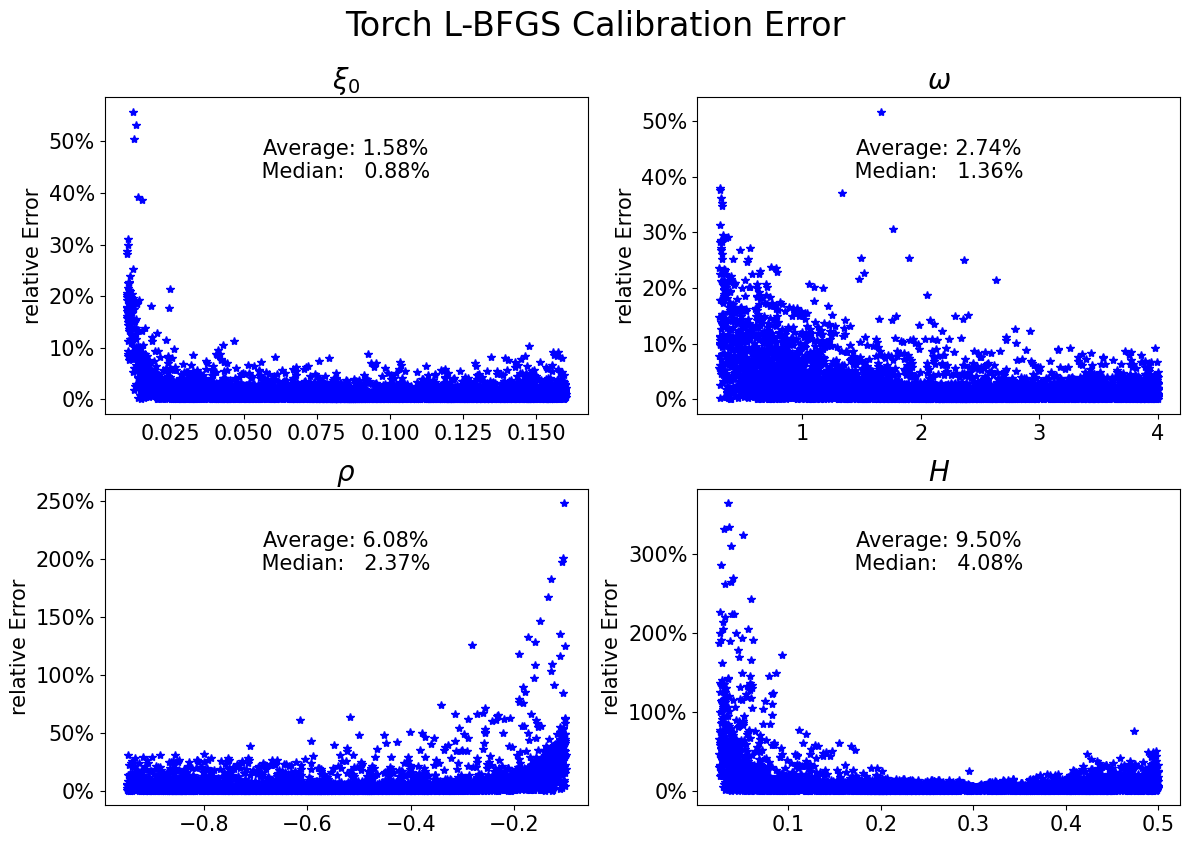

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

titles = ["$\\xi_0$","$\\omega$","$\\rho$","$H$"]

average = np.zeros([4,6000])
fig = plt.figure(figsize=(12,8))
for u in range(4): 
    ax = plt.subplot(2, 2, u+1)
    x = x_test[:6000, u]
    plt.plot( 
        x, 
        100 * np.abs( Approx_torch[:6000, u] - x ) / np.abs(x), 
        'b*'
    )
    average[u,:]=np.abs(Approx_torch[:6000,u]-x)/np.abs(x)

    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()
plt.suptitle("Torch L-BFGS Calibration Error", fontsize=24, y=1.05)

## 校准——基于 `SciPy`

利用 L-BFGS-B、SLSQP、BFGS三种拟牛顿算法做反向优化

In [ ]:
# 损失函数
def CostFunc(x,sample_ind):
    return np.sum( 
        np.power((model(torch.from_numpy(x)).detach().numpy() - y_test_transform[sample_ind]),2)
    )


import time
import scipy
Approx_scipy, Timing_scipy = [], [] 
solutions = np.zeros([3,4])
times = np.zeros(3)
init = np.zeros(4)

for i in range(x_test_transform.shape[0]):
    disp=str(i+1)+f"/{x_test_transform.shape[0]}"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[0,:]=params_inv_scaler(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[1,:]=params_inv_scaler(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[2,:]=params_inv_scaler(I.x)
    times[2]=end-start
    
    Approx_scipy.append(np.copy(solutions))
    Timing_scipy.append(np.copy(times))

Approx_scipy = np.array(Approx_scipy)
print(f"SciPy 优化结果 (前 10 个): {Approx_scipy[:10]}")
print(f"SciPy 优化时间 (前 10 个): {Timing_scipy[:10]}")

SciPy 优化结果 (前 10 个): [array([[ 0.10538894,  0.59271956, -0.7128344 ,  0.23465488],
       [ 0.10538895,  0.59271944, -0.71283453,  0.23465483],
       [ 0.10538895,  0.59271942, -0.71283459,  0.23465487]]), array([[ 0.15448516,  3.32790323, -0.463257  ,  0.28685762],
       [ 0.15448521,  3.32790473, -0.46325685,  0.28685753],
       [ 0.15448516,  3.32790322, -0.46325701,  0.28685762]]), array([[ 0.09260387,  1.99455838, -0.61660608,  0.14601958],
       [ 0.09260388,  1.99455852, -0.6166061 ,  0.14601952],
       [ 0.09260388,  1.99455835, -0.61660609,  0.14601957]]), array([[ 0.03370619,  1.15612154, -0.59544311,  0.22034956],
       [ 0.03370619,  1.15612144, -0.5954432 ,  0.2203496 ],
       [ 0.03370619,  1.15612153, -0.59544312,  0.22034955]]), array([[ 0.07547601,  0.65875301, -0.35767847,  0.11043722],
       [ 0.075476  ,  0.65875365, -0.35767805,  0.11043712],
       [ 0.07547601,  0.65875301, -0.35767847,  0.1104372 ]]), array([[ 0.02672967,  3.36965286, -0.7338666 ,  0.174

## 可视化

### 校准时间

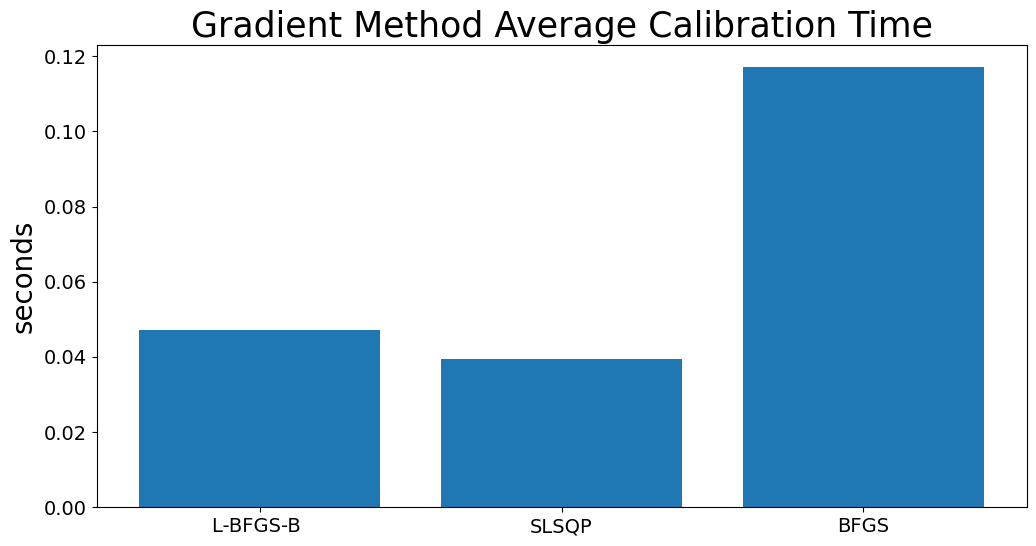

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing_scipy,axis=0))
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("seconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

### 误差